In [1]:
import pandas as pd
from tqdm import tqdm

result_df = []
for i in tqdm(range(0, 600, 100)):
    result_dict = pd.read_pickle(f'tpfy/neural_linUCB_before_relu/validation_dumping_dict/validation_stats_run_{i}.pkl')
    df = pd.DataFrame.from_dict(result_dict, orient='index').T
    result_df.append(df)
    
result_df = pd.concat(result_df).reset_index(drop = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]


In [2]:
content_popularity_tag = pd.read_csv('Content_popularity_tag_26Jan_to_1Feb.csv')
content_popularity_tag.drop_duplicates(subset=['sub_title_id'], inplace = True)
content_popularity_tag.reset_index(drop = True, inplace = True)
content_popularity_dict = content_popularity_tag.set_index('sub_title_id')['popularity_tag'].to_dict()    

result_df['popularity_category'] = result_df['content_ids'].apply(lambda x: content_popularity_dict.get(int(x)))
result_df['popularity_category'] = result_df['popularity_category'].fillna('Unmapped')

In [3]:
result_df.shape, result_df['dw_p_ids'].nunique()

((307200, 7), 47480)

In [4]:
result_df.groupby(['dw_p_ids','timestamps'])['content_ids'].count().describe(percentiles = [x/10 for x in range(10)])

count    47695.000000
mean         6.440927
std          1.979903
min          3.000000
0%           3.000000
10%          5.000000
20%          5.000000
30%          5.000000
40%          5.000000
50%          6.000000
60%          6.000000
70%          7.000000
80%          8.000000
90%          9.000000
max         31.000000
Name: content_ids, dtype: float64

In [5]:
from sklearn.metrics import ndcg_score
import numpy as np

def calculate_ndcg(group, predictions, labels, k_val):
    if len(group) < k_val:
        return np.nan 
    
    y_true = np.asarray([group[labels].values.astype(float)])
    y_score = np.asarray([group[predictions].values.astype(float)])
    
    if len(np.unique(y_true)) == 1:
        return 0.0

    return ndcg_score(y_true, y_score, k=k_val)

def popularity_dist_at_rank(df, score, rank = 1):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    df = df[df['rank'] <= rank].reset_index(drop = True)
    distribution_dict = df.groupby('popularity_category')['content_ids'].count().to_dict()
    return {k: round(100 * (v/sum(distribution_dict.values())), 2) for k, v in distribution_dict.items()}

In [6]:
result_df.isna().sum()

dw_p_ids               0
timestamps             0
content_ids            0
deepFMpredictions      0
labels                 0
variances              0
popularity_category    0
dtype: int64

In [7]:
result_df.dropna(inplace = True)

<AxesSubplot:>

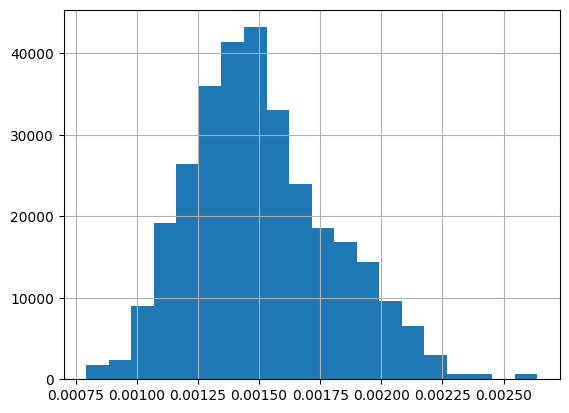

In [8]:
result_df['variances'].hist(bins = 20)

<AxesSubplot:>

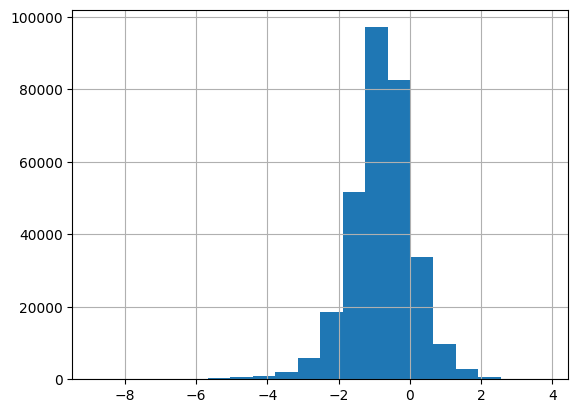

In [9]:
result_df['deepFMpredictions'].hist(bins = 20)

In [10]:
tqdm.pandas()

mu_variances = result_df['variances'].mean()
sigma_variances = result_df['variances'].std()

mu_deepFMscore = result_df['deepFMpredictions'].mean()
sigma_deepFMscore = result_df['deepFMpredictions'].std()

In [11]:
result_df['variances_rescaled'] = result_df['variances'].progress_apply(lambda x: ((x - mu_variances) / sigma_variances) * sigma_deepFMscore + mu_deepFMscore)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307200/307200 [00:00<00:00, 800507.33it/s]


<AxesSubplot:>

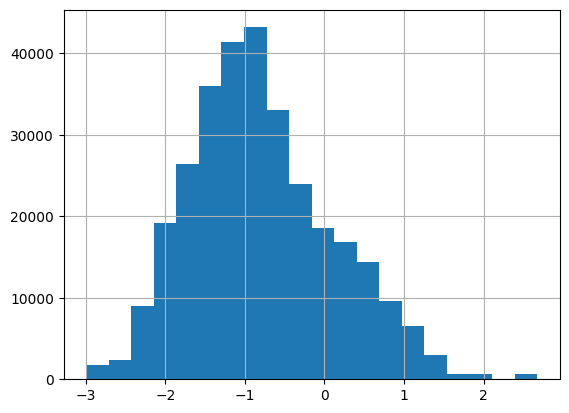

In [12]:
result_df['variances_rescaled'].hist(bins = 20)

In [13]:
result_df.groupby('popularity_category')['variances_rescaled'].mean()

popularity_category
High                  -0.797126
Low                   -0.790980
Medium                -0.790594
Negligible            -0.792140
Unmapped              -0.936939
Weekly New Releases   -0.792559
Name: variances_rescaled, dtype: float64

In [14]:
def evaluation_summary(df, alpha = 1, beta = 1, popularity_till = 1, k_val = 5):
    df['new_score'] = alpha * df['deepFMpredictions'] + beta * df['variances_rescaled']

    ndcg_results = df.groupby(['dw_p_ids', 'timestamps']).apply(
        lambda x: calculate_ndcg(x, predictions = 'new_score', labels = 'labels', k_val = k_val)
    ).reset_index(name=f'ndcg_score@{k_val}')
    mean_ndcg = ndcg_results[f'ndcg_score@{k_val}'].mean()
    print(f'Mean NDCG@{k_val} for this approach : {mean_ndcg}')

    popularity_dist_dict = popularity_dist_at_rank(df.copy(), 'new_score', rank = popularity_till)
    print(f'Popularity category distribution till rank {popularity_till}: {popularity_dist_dict}')
    
evaluation_summary(result_df, alpha=1, beta=0)

Mean NDCG@5 for this approach : 0.618199901640387
Popularity category distribution till rank 1: {'High': 11.56, 'Low': 31.27, 'Medium': 38.41, 'Negligible': 8.91, 'Unmapped': 0.01, 'Weekly New Releases': 9.84}


In [15]:
evaluation_summary(result_df, alpha=0, beta=1)

Mean NDCG@5 for this approach : 0.5455196473540448
Popularity category distribution till rank 1: {'High': 6.27, 'Low': 40.55, 'Medium': 38.62, 'Negligible': 10.98, 'Unmapped': 0.02, 'Weekly New Releases': 3.56}


In [16]:
evaluation_summary(result_df, alpha=1, beta=1)

Mean NDCG@5 for this approach : 0.5941205801439268
Popularity category distribution till rank 1: {'High': 9.21, 'Low': 35.08, 'Medium': 38.8, 'Negligible': 9.26, 'Unmapped': 0.01, 'Weekly New Releases': 7.63}


In [17]:
evaluation_summary(result_df, alpha=2, beta=1)

Mean NDCG@5 for this approach : 0.6087766835825162
Popularity category distribution till rank 1: {'High': 10.47, 'Low': 33.06, 'Medium': 38.37, 'Negligible': 9.05, 'Unmapped': 0.01, 'Weekly New Releases': 9.04}


In [18]:
evaluation_summary(result_df, alpha=1, beta=2)

Mean NDCG@5 for this approach : 0.5769456339133168
Popularity category distribution till rank 1: {'High': 8.03, 'Low': 37.39, 'Medium': 38.98, 'Negligible': 9.85, 'Unmapped': 0.01, 'Weekly New Releases': 5.74}
